# All the packages that need to be imported 

In [18]:
import numpy as np
import scipy
from scipy import linalg
import pandas as pd
import altair as alt
import seaborn as sns

# Define the Q-Matrix that you will be using for this experiment 

In [2]:
Q=np.fromstring("-0.8655 0.121 0.1864 0.337 0.0631 0.158 0.148 -0.8782 0.3739 0.1349 0.0632 0.1582 0.1461 0.2398 -1.0823 0.1333 0.4073 0.1558 0.3692 0.1209 0.1863 -1.0079 0.0947 0.2368 0.1468 0.1203 1.2085 0.201 -1.9125 0.2359 0.1471 0.1205 0.185 0.2012 0.0944 -0.7482", dtype=float, sep=" ").reshape(6,6)
Q

array([[-0.8655,  0.121 ,  0.1864,  0.337 ,  0.0631,  0.158 ],
       [ 0.148 , -0.8782,  0.3739,  0.1349,  0.0632,  0.1582],
       [ 0.1461,  0.2398, -1.0823,  0.1333,  0.4073,  0.1558],
       [ 0.3692,  0.1209,  0.1863, -1.0079,  0.0947,  0.2368],
       [ 0.1468,  0.1203,  1.2085,  0.201 , -1.9125,  0.2359],
       [ 0.1471,  0.1205,  0.185 ,  0.2012,  0.0944, -0.7482]])

# Below are all the functions that are needed 

In [3]:
def expected_number_of_transitions_in_time_t_final(array_step, Q):  
    eigenvalue,eigenvector = np.linalg.eig(Q)
    eigenvector_inv = np.linalg.inv(eigenvector)
    E_n = np.zeros_like(Q)
    for i in range(Q.shape[0]):
        d_i=eigenvalue[i]
        E_i = np.zeros_like(Q)
        E_i[i,i]=1
        S_i = eigenvector @ E_i @ eigenvector_inv
        for j in range(Q.shape[0]):
            d_j=eigenvalue[j]
            E_j = np.zeros_like(Q)
            E_j[j,j]=1
            S_j= eigenvector @ E_j @ eigenvector_inv           
            if d_i == d_j:
                I_ij = array_step * np.exp(d_i*array_step)
            else: 
                I_ij = (np.exp(d_i*array_step) - np.exp(d_j*array_step)) / (d_i - d_j)
            N_greek=S_i @ Q @ S_j * I_ij
            E_n += N_greek         
    return E_n

In [8]:
def simulated_number_of_transitions(array_step, first, last, Q):
    Q_array=np.array(Q)
    Q_exponential=scipy.linalg.expm(Q*1000)
    probability_distribution = Q_exponential[0]
    transitions=[]
    for simulation_trials in range(5000):
        states=[]
        time_passed=0
        
        first_state=np.random.choice(6, 1, p=[0.1814796, 0.1484505, 0.23148469, 0.16563497, 0.07801549, 0.19493475])
        state=int("".join(map(str, first_state)))
        while time_passed < array_step:
            new_time = np.random.exponential(1/Q_array[state, (Q_array[state] >= 0)].sum())
            time_passed += new_time
            new_state = np.random.choice(6, 1, p=probability_distribution)
            states.append(new_state)
            current_state=states[-1]
            if (first_state == first and current_state == last):
                transitions.append(states)
    return float ((len(transitions))/5000.0)

In [9]:
def simulated_Q_Matrix(array_step):
    simulated_Q_array = []
    for i in range(Q.shape[0]):
        first = i
        for j in range(Q.shape[0]):
            last = j
            cell_value = simulated_number_of_transitions(array_step, first, last, Q)
            if(first == i and last == j):
                simulated_Q_array.append(cell_value)
    simulated_Q_matrix = np.reshape(simulated_Q_array, (6,6))
    return simulated_Q_matrix

In [11]:
array = np.arange(0.1, 2, 0.1)
for array_step in array:
    difference_in_transitions = simulated_Q_Matrix(array_step) - expected_number_of_transitions_in_time_t_final(array_step, Q)

# Heat Maps at time step=1
## 1st Heat map is of the simulation
## 2nd Heat map is of the computed number of transitions

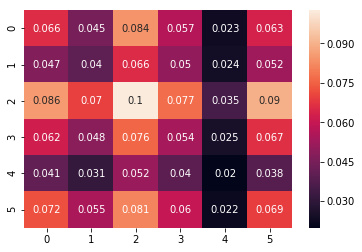

In [20]:
sns.heatmap(simulated_Q_Matrix(1), annot=True)

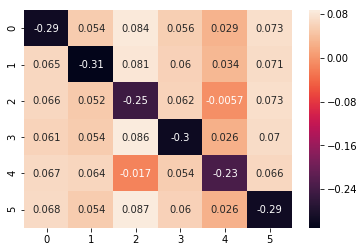

In [22]:
sns.heatmap(expected_number_of_transitions_in_time_t_final(1, Q), annot=True)

# I found the difference of the two matrices and converted the difference data into a Data Frame

In [ ]:
c = []
array = np.arange(0.1, 2, 0.1)
for t in array:
    array_step = t
    difference_in_transitions = simulated_Q_Matrix(array_step) - expected_number_of_transitions_in_time_t_final(array_step, Q)
    for i in range(Q.shape[0]):
        for j in range(Q.shape[0]):
            diagonal = True
            if(i == j):
                diagonal = True
            else:
                diagonal = False
            d = {'Time': array_step, 'Start State': [i], 'End State': [j], 'Difference': difference_in_transitions[i,j],'Diagonal': diagonal}
            c.append(d)
df= pd.DataFrame(data=c, columns=['Time','Start State','End State','Difference', 'Diagonal'])
df[0:10]

# I plotted the differences of the data frames.
## The orange dots are the states that are at the ii-th entry
## The blue dots are the states that are at the ij-th entry
### For the most part the difference lie on the line of zero, but there is a weird patter that is hard to explain

C:\Users\simon\Anaconda3\Lib\site-packages\altair\utils\core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


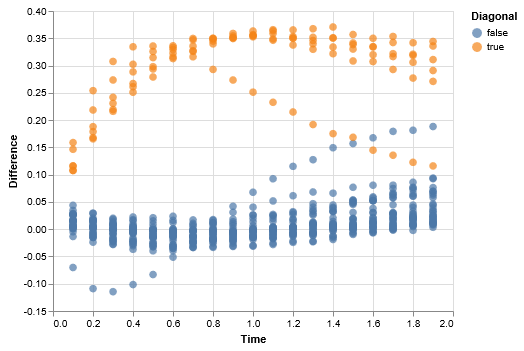

In [14]:
alt.Chart(df).mark_circle(size=60).encode(
    x='Time',
    y='Difference',
    tooltip=['Difference', 'Start State', 'End State', 'Time'],
    color= 'Diagonal:N'
).interactive()